# SVM: Spam link detection system

In [ ]:
#Libraries
import pandas as pd
import regex as re
from sklearn.metrics import classification_report
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from pickle import dump

**STEP 1: PROBLEM STATEMENT & DATA COLLECTION**

***1.1 PROBLEM STATEMENT***

**Goal** - implement a system that is able to automatically detect whether a web page contains spam or not based on its URL.

***1.2 DATA COLLECTION***

In [108]:
pd.options.display.max_columns=None
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [109]:
total_data.to_csv("../data/raw/url_spam.csv", index=False)

**STEP 2: EXPLORATION & DATA CLEANING**

**2.1 DATA EXPLORATION**

In [110]:
# Obtaining Dataset dimensions:
print("Dataset dimensions:")
print(total_data.shape)

Dataset dimensions:
(2999, 2)


In [111]:
# Obtaining Dataset informations:
print("Dataset informations:")
print(total_data.info())

Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB
None


**2.2 DATA PROCESSING & CLEANING**

***2.2.1 CATEGORICAL TO NUMERICAL TRANSFORMATION***

In [112]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


***2.2.2 ELIMINATE DUPLICATES***

In [113]:
data = total_data.drop_duplicates().reset_index(inplace=False, drop=True)
data.shape

(2369, 2)

#### Statement:
* 630 repeated records have been eliminated.

In [114]:
# Counting classes (spam and no spam)
print(f"URLs marked as spam: {data['is_spam'].sum()}")
print(f"URLs marked as no spam:: {len(data) - data['is_spam'].sum()}")

URLs marked as spam: 244
URLs marked as no spam:: 2125


In [115]:
# another way
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

Spam: 244
No spam: 2125


***2.2.2 TEXT PROCESSING***

In [116]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

data["url"] = data["url"].apply(preprocess_text)
data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [117]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

data["url"] = data["url"].apply(lemmatize_text)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ritin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


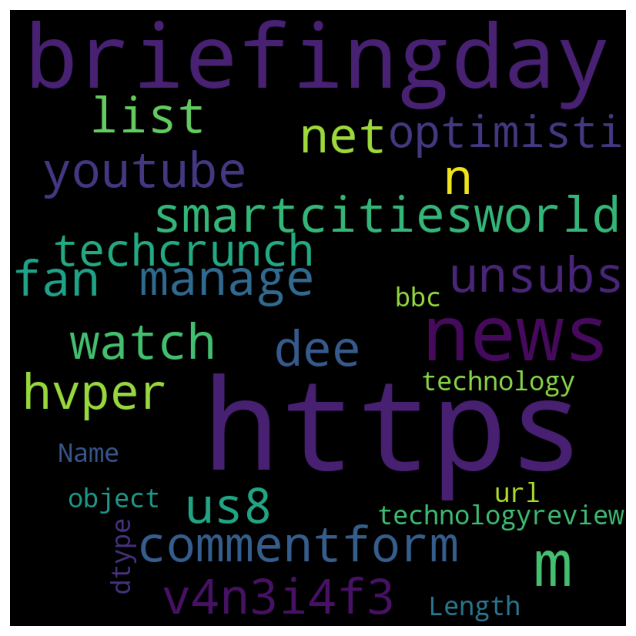

In [118]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [119]:
tokens_list = data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**2.3 TRAIN TEST SPLIT**

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**STEP 3: INICIALIZATION AND TRAINING OF THE MODEL**

In [125]:
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

**STEP 4: MODEL PREDICTION**

In [126]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [127]:
accuracy_score(y_test, y_pred)

0.9514767932489452

In [ ]:
# Evaluating the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       435
           1       0.83      0.51      0.63        39

    accuracy                           0.95       474
   macro avg       0.90      0.75      0.80       474
weighted avg       0.95      0.95      0.95       474



 ## **OPTIMIZING SVC MODEL**

In [135]:
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": [0.1, 0.5, 1]
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_optimized = best_model.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

Best parameters: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       435
           1       0.95      0.51      0.67        39

    accuracy                           0.96       474
   macro avg       0.96      0.76      0.82       474
weighted avg       0.96      0.96      0.95       474



**STEP 5: SAVING THE MODEL**

In [138]:
dump(model, open("svm_classifier_C-1_gam-0.5_rbf_42.sav", "wb"))